<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Statistical-Data-Analysis-2/blob/master/LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SAD2 Lab3: Modeling and simulating Markov Chains**
*Justyna Król*

### **Introduction**

A Markov chain is a way to describe a system that moves between different situations called "states", where the chain assumes the probability of being in a particular state at the next step depends solely on the current state. This key property of ignoring historical states is called the Markov Property or memorylessness and is written as

$$
P(X_{t+1} = j \mid X_t, X_{t-1}, \dots, X_0) = P(X_{t+1} = j \mid X_t = i).
$$

A discrete, time-homogeneous Markov chain on states $S = {1, \dots, N}$ is defined by an $N \times N$ transition matrix $P$. The transition matrix encodes the probabilities of moving from each state to every other state. Each row sums to 1 and represents the conditional distribution of the next state given the current state:

$$
P_{ij} = P(X_{t+1}=j \mid X_t=i).
$$


A stationary distribution $\pi$, which represents the long-term, steady-state probabilities of being in each state, satisfies

$$
\pi P = \pi, \qquad \sum_i \pi_i = 1.
$$

If the chain is ergodic (irreducible and aperiodic), then regardless of the initial state distribution, the empirical frequencies of states converge to $\pi$.



### **Task 1:**
In this task we will implement the core components of a Markov chain. We will:
- Generate a random transition probability matrix $P$.
- Simulate a long state sequence using $P$.
- Estimate the empirical (sample) stationary distribution from the simulated sequence.
- Compute the analytical stationary distribution by solving $\pi P = \pi$.
- Compare and visualize both distributions.
- Plot the evolution of state probabilities over time to observe convergence.


In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

def set_seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

Step 1: Define a random transition matrix.

You may either specify your own transition probabilities manually or generate them randomly.
Ensure that each row of the matrix represents a valid probability distribution - all entries must be non-negative and each row sums to 1.

In [10]:
set_seed(42)
num_states = 5

P = torch.rand(num_states, num_states)
P = P / P.sum(dim=1, keepdim=True)
print("Transition Matrix P:\n", P)

Transition Matrix P:
 tensor([[0.2499, 0.2592, 0.1085, 0.2718, 0.1106],
        [0.2205, 0.0942, 0.2912, 0.3452, 0.0489],
        [0.2522, 0.1602, 0.2346, 0.1532, 0.2000],
        [0.1543, 0.3182, 0.2062, 0.0958, 0.2255],
        [0.1386, 0.2269, 0.1527, 0.4276, 0.0541]])


Step 2: Write a function `simulate_markov_chain(P, initial_state, num_steps)` that simulates the evolution of a Markov chain.

The function should:

- Start from `initial_state`.
- At each step, sample the next state according to the probability distribution defined by the transition matrix `P` (Hint: use `torch.multinomial`)
- Append the sampled state to a tensor or list.
- Return the full sequence of states after `num_steps` transitions.

This sequence can then be used to estimate the empirical stationary distribution and analyze the chain’s long-term behavior.



In [11]:
def simulate_markov_chain(P, initial_state, n_steps):
    # TODO
    results = []
    for i in range(n_steps):
        results.append(initial_state)
        initial_state = torch.multinomial(P[initial_state], 1).item()
    return results


# Example simulation
initial_state = 0
n_steps = 1000
new_sequence = simulate_markov_chain(P, initial_state, n_steps)
print("First 20 states of simulation:", new_sequence[:20])

First 20 states of simulation: [0, 2, 1, 0, 3, 0, 3, 0, 4, 0, 1, 2, 1, 4, 0, 0, 3, 0, 0, 1]


Step 3: Estimate the stationary distribution and compare it with the analytical stationary distribution.

Use the simulated state sequence to compute the *empirical stationary distribution*, given by the long-run relative frequency of each state:
$$
\hat{\pi}_i = \frac{1}{T} \sum_{t=1}^T \mathbf{1}_{\{X_t = i\}}.
$$
Then compute the *analytical stationary distribution* $\pi$ by solving the equation $\pi P = \pi$ under the constraint $\sum_i \pi_i = 1$.  
Compare the empirical and analytical results to verify that the simulation outcomes converge to the theoretical predictions as $T$ increases.

In [18]:
def estimate_stationary_distribution(sequence):
  # TODO
  sequence_tensor = torch.tensor(sequence)
  num_states = len(torch.unique(sequence_tensor))
  n_steps = len(sequence_tensor)
  empirical_pi = torch.zeros(num_states)
  for state in range(num_states):
    empirical_pi[state] = (sequence_tensor == state).sum().item()
  empirical_pi = empirical_pi / n_steps
  return empirical_pi

# Analytical stationary distribution: solve πP = π  <=> (P^T - I) π^T = 0
def analytical_stationary_distribution(P):
  num_states = P.shape[0]
  A = P.T - torch.eye(num_states)
  # Append constraint sum(pi)=1
  A = torch.cat([A, torch.ones(1, num_states)], dim=0)
  b = torch.zeros(num_states + 1)
  b[-1] = 1.0
  # Solve least squares
  analytical_pi = torch.linalg.lstsq(A, b.unsqueeze(1)).solution[:num_states].squeeze()
  analytical_pi = analytical_pi / analytical_pi.sum()  # normalize
  return analytical_pi

empirical_pi = estimate_stationary_distribution(new_sequence)
analytical_pi = analytical_stationary_distribution(P)
print("Empirical stationary distribution:", empirical_pi)
print("Analytical stationary distribution:", analytical_pi)

Empirical stationary distribution: tensor([0.2160, 0.2090, 0.2050, 0.2320, 0.1380])
Analytical stationary distribution: tensor([0.2059, 0.2137, 0.2028, 0.2420, 0.1357])


Step 4: Create a bar plot comparing the empirical stationary distribution $\hat{\pi}$ and the analytical stationary distribution $\pi$.

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3386277112.py:6: SyntaxWarning: invalid escape sequence '\h'
  plt.bar(states - 0.2, empirical_pi.numpy(), 0.4, label='Empirical $\hat{\pi}$')
/tmp/ipython-input-3386277112.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.bar(states + 0.2, analytical_pi.numpy(), 0.4, label='Analytical $\pi$')


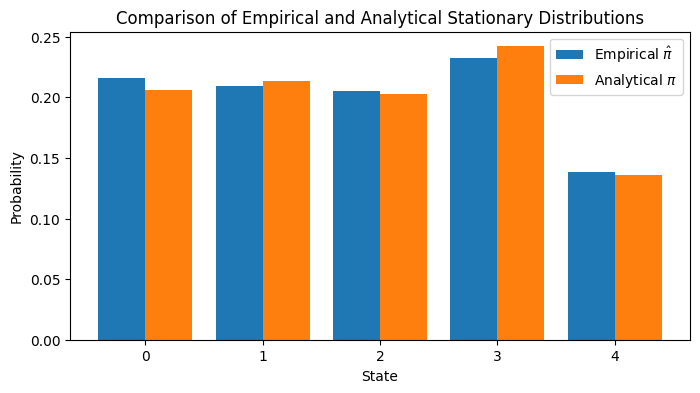

In [19]:
# TODO
num_states = P.shape[0]
states = np.arange(num_states)

plt.figure(figsize=(8, 4))
plt.bar(states - 0.2, empirical_pi.numpy(), 0.4, label='Empirical $\hat{\pi}$')
plt.bar(states + 0.2, analytical_pi.numpy(), 0.4, label='Analytical $\pi$')
plt.xticks(states)
plt.xlabel("State")
plt.ylabel("Probability")
plt.title("Comparison of Empirical and Analytical Stationary Distributions")
plt.legend()
plt.show()

Step 5: Observe how the probabilities of being in each state evolve as the Markov chain progresses and how they converge to the stationary distribution. For each time step $t$, compute the running frequencies of each state $i$:
$$
\hat{\pi}_i(t) = \frac{1}{t} \sum_{s=1}^{t} \mathbf{1}_{\{X_s = i\}},
$$

Use a line plot to visualize $\hat{\pi}_i(t)$ for all states $i$ as a function of time. This plot illustrates the convergence behavior of the chain toward its stationary distribution.

tensor([[1.0000, 0.5000, 0.3333,  ..., 0.2164, 0.2162, 0.2160],
        [0.0000, 0.0000, 0.3333,  ..., 0.2094, 0.2092, 0.2090],
        [0.0000, 0.5000, 0.3333,  ..., 0.2044, 0.2052, 0.2050],
        [0.0000, 0.0000, 0.0000,  ..., 0.2325, 0.2322, 0.2320],
        [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1371, 0.1380]])


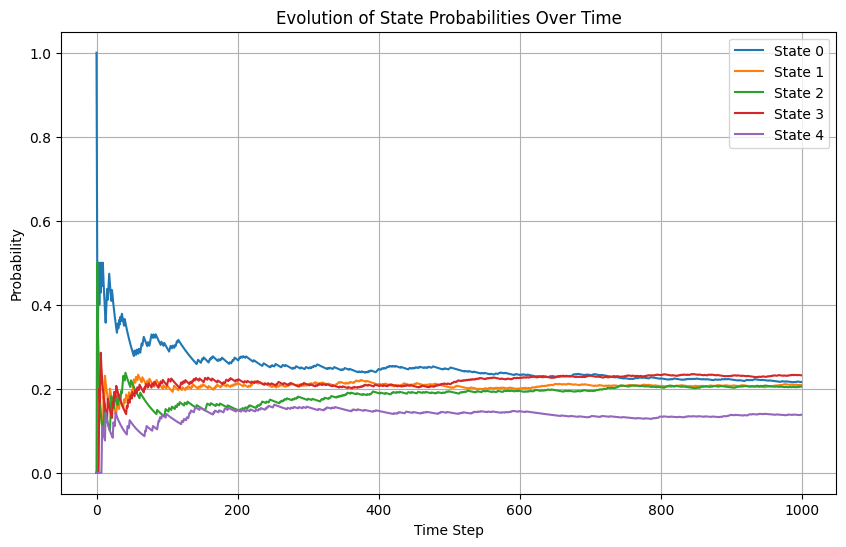

In [22]:
# Calculate state probabilities over time


def estimate_stationary_distribution_over_time(sequence):
  # TODO
  sequence_tensor = torch.tensor(sequence)
  num_states = len(torch.unique(sequence_tensor))
  n_steps = len(sequence_tensor)
  empirical_pi_t = torch.zeros(num_states, n_steps)
  for state in range(num_states):
    empirical_pi_t[state] = (sequence_tensor == state).cumsum(dim=0).int() / torch.arange(1, n_steps + 1)
  return empirical_pi_t

empirical_pi_t = estimate_stationary_distribution_over_time(new_sequence)
print(empirical_pi_t)
# Create a line plot showing the running frequencies of each state

plt.figure(figsize=(10, 6))
for state in range(num_states):
    plt.plot(empirical_pi_t[state], label=f'State {state}')
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.title("Evolution of State Probabilities Over Time")
plt.legend()
plt.grid(True)
plt.show()

### **Task 2:** Amino acid sequence modeling

Proteins are composed of sequences of amino acids, and their biological function is determined by the specific arrangement of these amino acids. Understanding the statistical properties of amino acid sequences is essential in bioinformatics, for tasks such as protein family classification, motif discovery, and evolutionary analysis.

In this task, each state of the Markov chain will correspond to one of the 20 standard amino acids, and the transition probabilities will capture how likely one amino acid is to follow another in a protein sequence. We will build the transition matrix $P$ based on a real amino acid sequence.

In [26]:
sequence = 'MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPTWLAINKVFCNKASIRIPWTKLKTHPICLSLDKVIMEMSTCEEPRSPNGPSPIATASGQSEYGFAEKVVEGISVSVNSIVIRIGAKAFNASFELSQLRIYSVNAHWEHGDLRFTRIQDPQRGEVLTFKEINWQMIRIEADATQSSHLEIMCAPVRLITNQSKIRVTLKRRLKDCNVIATKLVLILDDLLWVLTDSQLKAMVQYAKSLSEAIEKSTEQRKSMAPEPTQSSTVVASAQQVKTTQTSNAPDVNDAIVKLFNDFDVKETSHHLVISHLDLHICDDIHAKEKESNRRITGGAMQLSFTQLTIDYYPYHKAGDSCNHWMYFSDATKTKNGWANELLHEFECNVEMLKQAVKDHNVGSPPKSPTHASPQHTQTEKDYPLKGTCRTPSVLSQQSKAKLMSSSVVVRLADFNIYQVSTAEQCRSSPKSMICCNKKSLYLPQEMSAVYIEFTEYYYPDGKDFPIPSPNLYSQLNALQFTVDERSILWLNQFLLDLKQSLNQFMAVYKLNDNSKSDEHVDVRVDGLMLKFVIPSEVKSECHQDQPRAISIQSSEMIATNTRHCPNCRHSDLEALFQDFKDCDFFSKTYTSFPKSCDNFNLLHPIFQRHAHEQDTKMHEIYKGNITPQLNKNTLKTSAATDVWAVYFSQFWIDYEGMKSGKGRPISFVDSFPLSIWICQPTRYAESQKEPQTCNQVSLNTSQSESSDLAGRLKRKKLLKEYYSTESEPLTNGGQKPSSSDTFFRFSPSSSEADIHLLVHVHKHVSMQINHYQYLLLLFLHESLILLSENLRKDVEAVTGSPASQTSICIGILLRSAELALLLHPVDQANTLKSPVSESVSPVVPDYLPTENGDFLSSKRKQISRDINRIRSVTVNHMSDNRSMSVDLSHIPLKDPLLFKSASDTNLQKGISFMDYLSDKHLGKISEDESSGLVYKSGSGEIGSETSDKKDSFYTDSSSILNYREDSNILSFDSDGNQNILSSTLTSKGNETIESIFKAEDLLPEAASLSENLDISKEETPPVRTLKSQSSLSGKPKERCPPNLAPLCVSYKNMKRSSSQMSLDTISLDSMILEEQLLESDGSDSHMFLEKGNKKNSTTNYRGTAESVNAGANLQNYGETSPDAISTNSEGAQENHDDLMSVVVFKITGVNGEIDIRGEDTEICLQVNQVTPDQLGNISLRHYLCNRPVGSDQKAVIHSKSSPEISLRFESGPGAVIHSLLAEKNGFLQCHIENFSTEFLTSSLMNIQHFLEDETVATVMPMKIQVSNTKINLKDDSPRSSTVSLEPAPVTVHIDHLVVERSDDGSFHIRDSHMLNTGNDLKENVKSDSVLLTSGKYDLKKQRSVTQATQTSPGVPWPSQSANFPEFSFDFTREQLMEENESLKQELAKAKMALAEAHLEKDALLHHIKKMTVE'

# Define states
states_amino = sorted(list(set(sequence)))
num_states_amino = len(states_amino)

print("Number of states:", num_states_amino)
print("States:", states_amino)
print("Sequence length:", len(sequence))

Number of states: 20
States: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Sequence length: 1464


Step 1: Write a function `get_transition_matrix` that estimates the transition matrix based on a sequence of states.
- Count how often each state is followed by every other state.
- Normalize each row so that the sum of probabilities is 1.

In [28]:
# Build the transition matrix
def get_transition_matrix(sequence):
  # TODO
  states_amino = sorted(list(set(sequence)))
  num_states_amino = len(states_amino)
  P = torch.zeros(num_states_amino, num_states_amino)
  for state_1 in states_amino:
    for state_2 in states_amino:
      count = 0
      for i in range(len(sequence)-1):
        if sequence[i] == state_1 and sequence[i+1] == state_2:
          count = count + 1
      P[states_amino.index(state_1), states_amino.index(state_2)] = count
    P[states_amino.index(state_1)] = P[states_amino.index(state_1)]/P[states_amino.index(state_1)].sum()
  return P


P_amino = get_transition_matrix(sequence)
print("Transition Matrix P:\n", P_amino)

Transition Matrix P:
 tensor([[0.0274, 0.0000, 0.0411, 0.1096, 0.0137, 0.0548, 0.0411, 0.0685, 0.0822,
         0.0685, 0.0274, 0.0548, 0.0685, 0.0274, 0.0000, 0.1096, 0.1096, 0.0959,
         0.0000, 0.0000],
        [0.0400, 0.0400, 0.1200, 0.0400, 0.0000, 0.0000, 0.0800, 0.0400, 0.0000,
         0.0800, 0.0000, 0.2800, 0.0800, 0.0400, 0.1200, 0.0000, 0.0000, 0.0400,
         0.0000, 0.0000],
        [0.0568, 0.0227, 0.0568, 0.0568, 0.0795, 0.0568, 0.0227, 0.0568, 0.0455,
         0.1364, 0.0000, 0.0341, 0.0227, 0.0455, 0.0000, 0.1364, 0.0568, 0.0568,
         0.0000, 0.0568],
        [0.0722, 0.0206, 0.0515, 0.0515, 0.0412, 0.0412, 0.0206, 0.0722, 0.0722,
         0.0619, 0.0412, 0.0722, 0.0515, 0.0515, 0.0309, 0.1237, 0.0619, 0.0309,
         0.0000, 0.0309],
        [0.0192, 0.0192, 0.0577, 0.0577, 0.0385, 0.0000, 0.0192, 0.0000, 0.0962,
         0.1346, 0.0385, 0.0769, 0.0769, 0.0385, 0.0192, 0.1154, 0.1154, 0.0385,
         0.0192, 0.0192],
        [0.0909, 0.0000, 0.0545, 0.127

Step 2: Simulate a new sequence using the transition matrix from step 1 and function `simulate_markov_chain` from Task 1. This time, the initial state should be chosen randomly according to the empirical probabilities of the states in the original sequence.

Calculate empirical and analytical stationary distributions using the functions from Task 1.

In [29]:
# Simulate new sequence
n_steps = 1000
initial_state_probs = torch.tensor([sequence.count(state) / len(sequence) for state in states_amino])
initial_state = torch.multinomial(initial_state_probs, 1).item()
print("Initial state:", initial_state)
simulated_states = simulate_markov_chain(P_amino, initial_state, n_steps)
print("\nSimulated sequence (first 100 characters):")
print(''.join([states_amino[i] for i in simulated_states[:100]]))

empirical_pi_amino = estimate_stationary_distribution(simulated_states)
analytical_pi_amino = analytical_stationary_distribution(P_amino)

print("\nEmpirical stationary distribution:", empirical_pi_amino)
print("Analytical stationary distribution:", analytical_pi_amino)

Initial state: 3

Simulated sequence (first 100 characters):
ETAGLSLHALEQKSPSLNICNSHMHETVWQTEDQSVELQDDAPKNIHNGEKGKDSPQFLDSGIQQNQDGSFTDICLQDLALGSQLNHDQSLKRIDSENDI

Empirical stationary distribution: tensor([0.0570, 0.0220, 0.0510, 0.0720, 0.0310, 0.0390, 0.0390, 0.0530, 0.0710,
        0.0950, 0.0210, 0.0560, 0.0460, 0.0480, 0.0370, 0.1220, 0.0510, 0.0600,
        0.0060, 0.0230])
Analytical stationary distribution: tensor([0.0499, 0.0171, 0.0602, 0.0670, 0.0356, 0.0376, 0.0328, 0.0574, 0.0711,
        0.0991, 0.0233, 0.0533, 0.0458, 0.0478, 0.0349, 0.1209, 0.0581, 0.0561,
        0.0082, 0.0239])


Step 3: Create the same two plots as in task 1.

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2063858960.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.bar(states_indices - 0.2, empirical_pi_amino.numpy(), 0.4, label='Empirical $\hat{\pi}$')
/tmp/ipython-input-2063858960.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.bar(states_indices + 0.2, analytical_pi_amino.numpy(), 0.4, label='Analytical $\pi$')


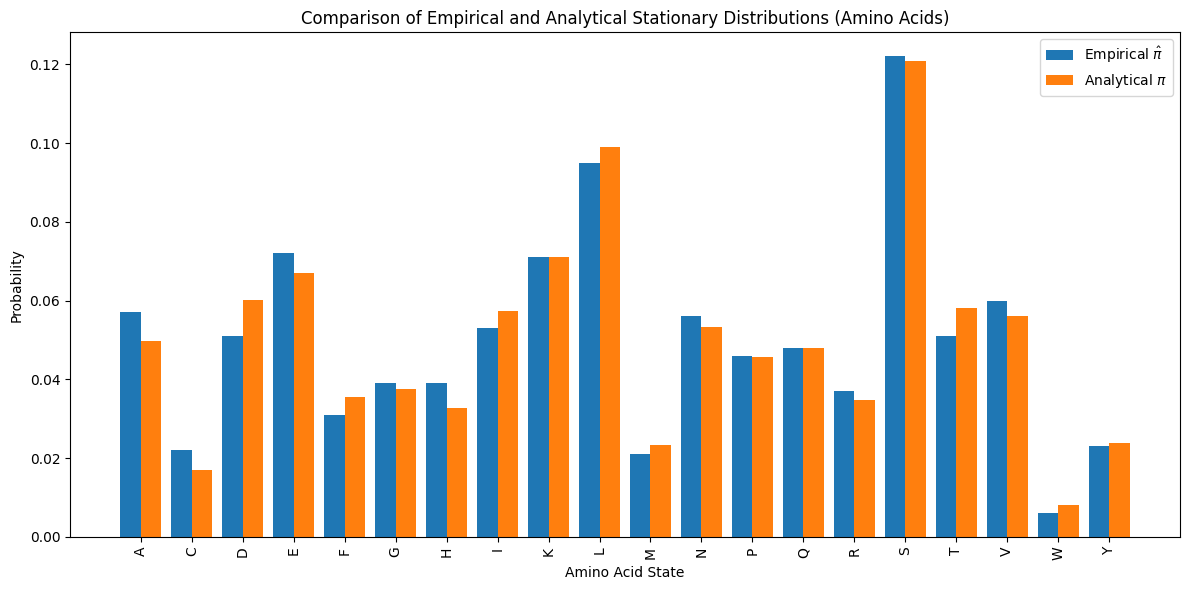

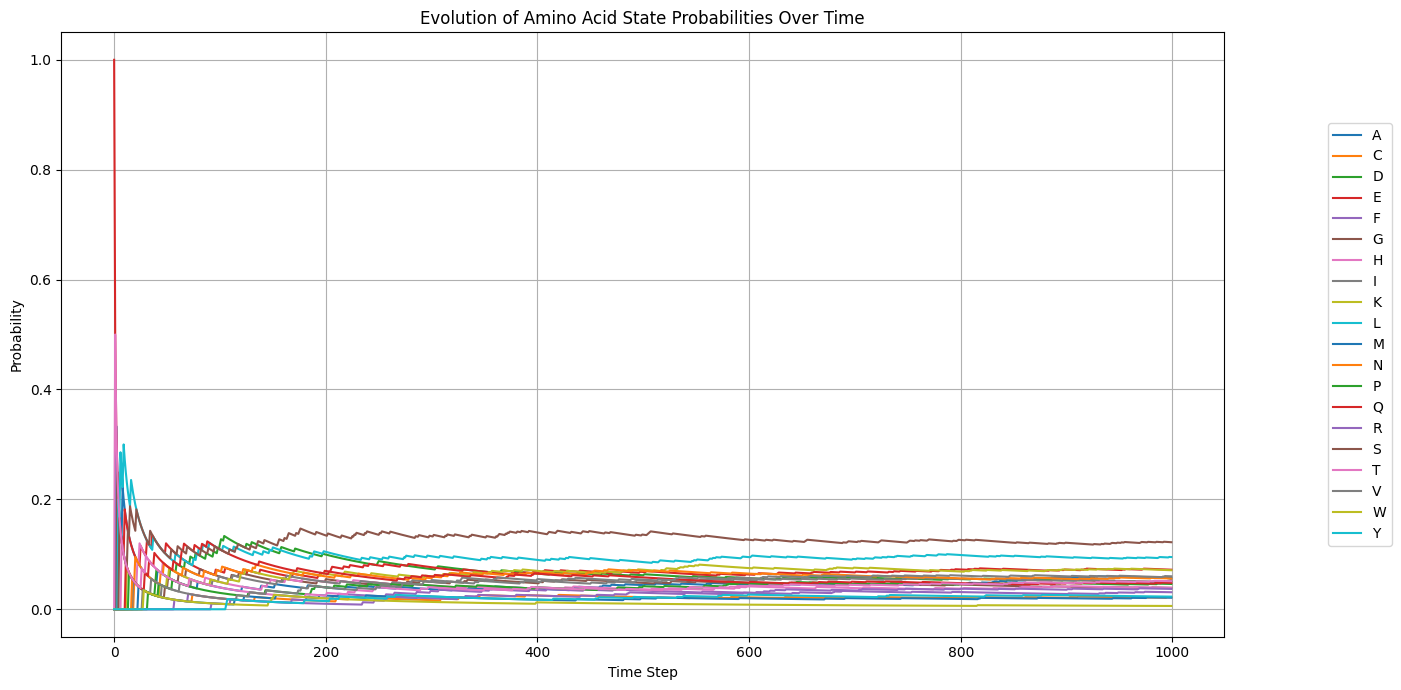

In [30]:
# TODO
num_states_amino = P_amino.shape[0]
states_indices = np.arange(num_states_amino)

# Bar plot for stationary distributions
plt.figure(figsize=(12, 6))
plt.bar(states_indices - 0.2, empirical_pi_amino.numpy(), 0.4, label='Empirical $\hat{\pi}$')
plt.bar(states_indices + 0.2, analytical_pi_amino.numpy(), 0.4, label='Analytical $\pi$')
plt.xticks(states_indices, states_amino, rotation=90)
plt.xlabel("Amino Acid State")
plt.ylabel("Probability")
plt.title("Comparison of Empirical and Analytical Stationary Distributions (Amino Acids)")
plt.legend()
plt.tight_layout()
plt.show()

# Line plot for evolution of state probabilities
empirical_pi_t_amino = estimate_stationary_distribution_over_time(simulated_states)

plt.figure(figsize=(14, 7))
for state in range(num_states_amino):
    plt.plot(empirical_pi_t_amino[state], label=f'{states_amino[state]}')
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.title("Evolution of Amino Acid State Probabilities Over Time")
plt.legend(loc='right', bbox_to_anchor=(1.15, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

Step 4: Simulate 10 sequences of the same length. Each time, the initial state should be chosen randomly, as in step 2.
Plot the evolution of observed probabilities of a chosen state in time for each simulated sequence. Comment the outcome.

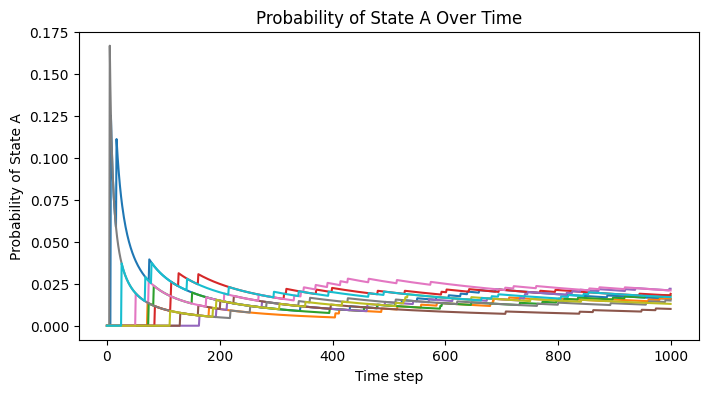

In [ ]:
n_steps = 1000
n_sequences = 10
state_probs = torch.zeros(n_sequences, n_steps)
for i in range(n_sequences):
    initial_state_probs = torch.tensor([sequence.count(state) / len(sequence) for state in states_amino])
    initial_state = torch.multinomial(initial_state_probs, 1).item()
    simulate_markov_chain(P_amino, initial_state, n_steps)

    def estimate_stationary_distribution_over_time_state(sequence, state):
  # TODO
      sequence_tensor = torch.tensor(sequence)
      num_states = len(torch.unique(sequence_tensor))
      n_steps = len(sequence_tensor)
      empirical_pi_t = torch.zeros(num_states, n_steps)
      for state in range(num_states):
        empirical_pi_t[state] = (sequence_tensor == state).cumsum(dim=0).int() / torch.arange(1, n_steps + 1)
      return empirical_pi_t